# Assignment 5

**Submission deadlines:**
- get at least 4 points by Tuesday, 8.06 
- remaining points: last lab session of the semester

**Points:** Aim to get 12 out of 16 possible points.


## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Problem 1: Generating 2 Moons data
Consider the 2D moons dataset generated in the starter code below. 

Train the following models: VAE, GAN, RealNVP. 

For each model visualize how the latent space is transformed into data points. Train a model with 2D latent space. Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

## Tasks:
1. [4p] Variational Autoencoder (VAE)

  Please use the following probability distributions:
    
  $$
    \begin{split}
    p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
    p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
    \end{split}
  $$

  where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible? 

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?

2. [3p] Generative Adversarial Network (GAN)

  Please use either a standard normal distribution for the latent space or a uniform distribution.

  **Answer these questions:**
  - Is the GAN generating all possible samples? Is it concentrating more on some regions of the data space?

3. [3p] Normalizing Flow (Real NVP model).

  The goal of Normalizing Flows is to learn invertible transformation between complex data distribution and some simple one, i.e. multivariate isotropic Gaussian. Since the latter is continuous, and our dataset is finite (hence in fact forms a discrete distribution, because you can memorize all observed values), we need to perform *dequantization*, that is add random noise to data at every iteration to train the model on an infinite stream of data. This is especially important in Problem 2 when RealNVP is applied to the MNIST data.

    **Answer these questions:**
  - Scale the input data by 0.01. Why is the negative log-likelihood negative?
  - For a few 2 moon widths compare the negative log-likelihood of the data with the values obtained with the VAE and present results in a table. How do they compare? Please note, that GAN's do not return likelihood computation.


# Problem 2: Generating MNIST

Next, choose one of the generative models (VAE, RealNVP, or GAN) and do the following using the MNIST dataset:

##Tasks
1. [2p] Train the model. Visualize generated samples (and test/train data reconstructions if you chose VAE).

Please properly define $p(x|z)$: when using a VAE, you can binarize the data and predict binary variables. For RealNVP, you can normalize the data to the 0-1 range, and add uniform noise $[0,1/255]$ to dequantize intensity values. GAN does not assume an output probability distribution and you may use raw data.

2. [1p] Linearly interpolate between two points in the latent space. Generate images from them and intermediate points. 

3. [1p] Try a different interpolation method, i.e. instead of going in a straight line from one point to another, follow the spherical curve of prior Gaussian distribution.

4. [2p] It is sometimes desirable to make use of available labels to gain control over classes of generated samples. Create a conditional generative model of your choice by injecting one-hot embeddings into the proper component(s). An example is [Conditional GAN](https://arxiv.org/abs/1411.1784), and its idea is applicable to other methods.


## Starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

import os
import time

from IPython.display import clear_output
from tqdm.auto import tqdm

from collections import defaultdict

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

import copy
device = "cuda"

## Data

In [ ]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [ ]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [ ]:
moons = generate_moons(width=1.0)
moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


## VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def forward(self, x):
        sampled_z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(sampled_z)
        return x_mu, x_log_var, z_mu, z_log_var

    def encode(self, x):
        # Implement encoding procedure.
        # First, get z_mu and z_log_var from the encoder.
        # Second, compute z samples using the  the reparametrization trick.
        # TODO
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
        epsilon = torch.randn(x.shape[0], z_dim, device=device)
        # print(MultivariateNormal(torch.zeros(z_dim, device=device), torch.eye(z_dim, device=device)).sample((x.shape[0],)).shape)
        # print(epsilon.shape)
        sampled_z = z_mu + torch.exp(z_log_var/2.) * epsilon
        return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [ ]:
def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    return (x-mu)**2 / (2*log_var.exp()) + (np.log(2*np.pi) + log_var)/2

def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    return (
        log_var2 - log_var1 + (log_var1.exp() + (mu1 - mu2) ** 2) / (log_var2.exp()) - 1
    ) / 2 


def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negtive log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    return gaussian_negative_log_likelihood(x=real_x, mu=predicted_x_mu, log_var=predicted_x_log_var).mean()


def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1).

    """
    return kullback_leibler_divergence_between_two_gaussians(z_mu, z_log_var, torch.zeros_like(z_mu) ,torch.ones_like(z_log_var)).mean()


In [ ]:
hid_dim = 64
z_dim = 2
lr = 0.0003

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

Epoch: 0 loss: 7.7594 recon_loss: 7.5217 kl_loss: 0.2377 avg mean: 0.1413 avg std: 0.9848


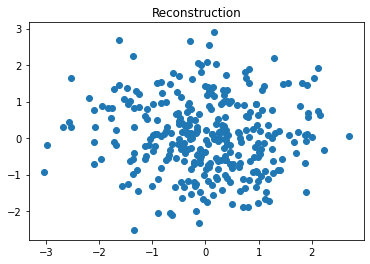

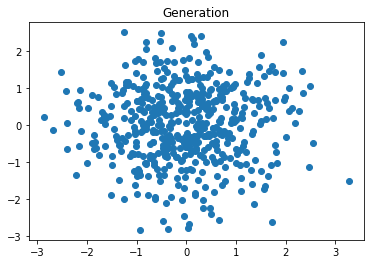

Epoch: 200 loss: 2.4864 recon_loss: 1.3933 kl_loss: 1.0931 avg mean: -0.0223 avg std: 0.5966


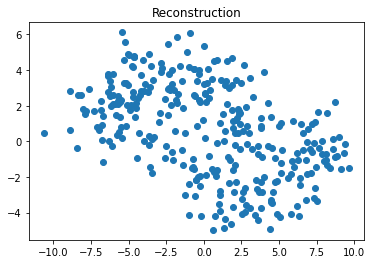

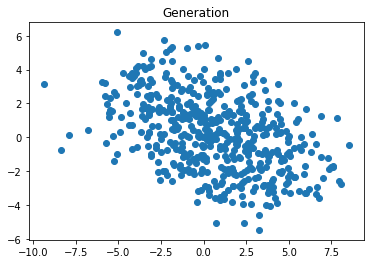

Epoch: 400 loss: 2.4549 recon_loss: 1.3665 kl_loss: 1.0884 avg mean: -0.0229 avg std: 0.6075


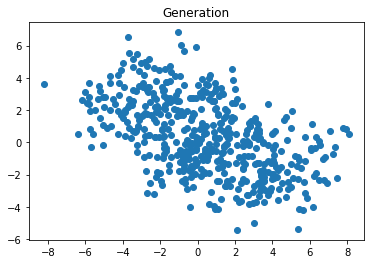

Epoch: 600 loss: 2.4284 recon_loss: 1.3149 kl_loss: 1.1135 avg mean: 0.1678 avg std: 0.6482


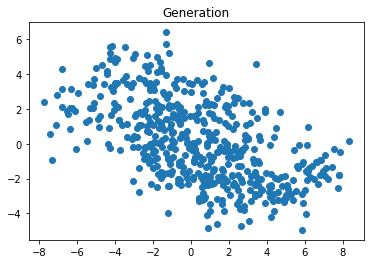

Epoch: 800 loss: 2.4018 recon_loss: 1.2229 kl_loss: 1.1789 avg mean: -0.0658 avg std: 0.6137


Epoch: 1000 loss: 2.3804 recon_loss: 1.1026 kl_loss: 1.2778 avg mean: 0.0781 avg std: 0.5892


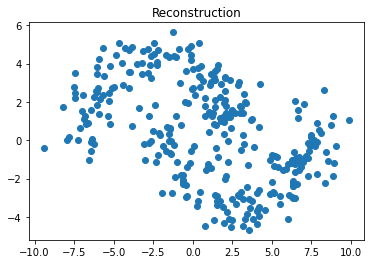

Epoch: 1200 loss: 2.3578 recon_loss: 0.9862 kl_loss: 1.3715 avg mean: -0.1234 avg std: 0.5233


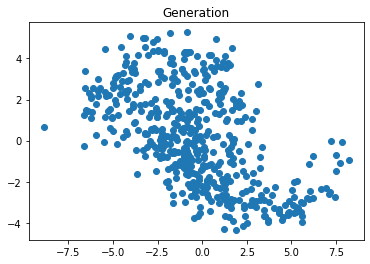

Epoch: 1400 loss: 2.3482 recon_loss: 0.8977 kl_loss: 1.4505 avg mean: -0.0355 avg std: 0.5165


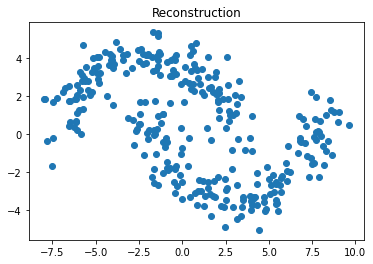

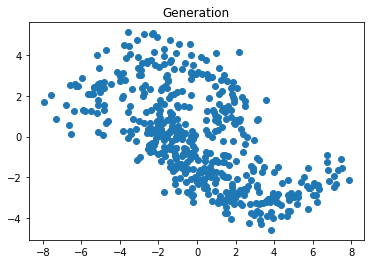

Epoch: 1600 loss: 2.3471 recon_loss: 0.8321 kl_loss: 1.5150 avg mean: -0.0088 avg std: 0.4940


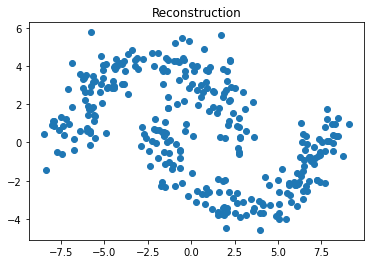

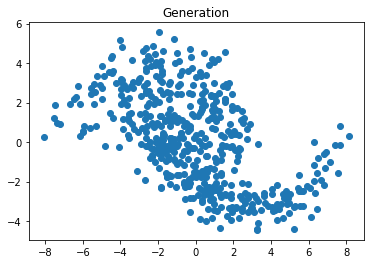

Epoch: 1800 loss: 2.3364 recon_loss: 0.7489 kl_loss: 1.5875 avg mean: -0.0309 avg std: 0.4534


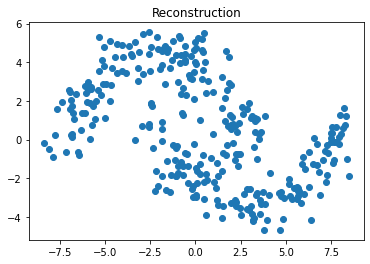

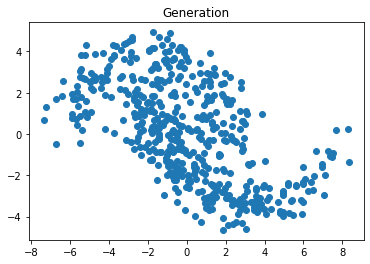

Epoch: 2000 loss: 2.3363 recon_loss: 0.6822 kl_loss: 1.6541 avg mean: 0.0189 avg std: 0.4371


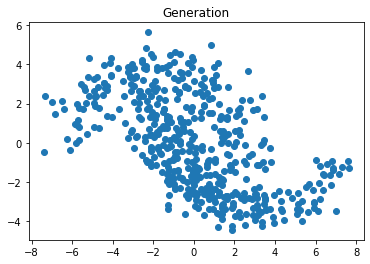

Epoch: 2200 loss: 2.3301 recon_loss: 0.5772 kl_loss: 1.7529 avg mean: 0.0542 avg std: 0.3795


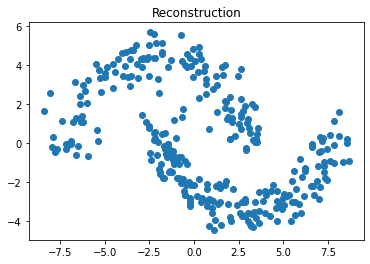

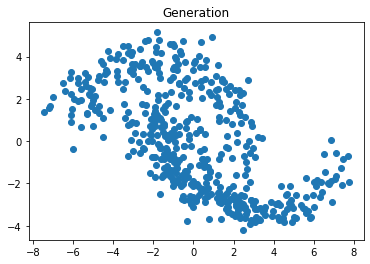

Epoch: 2400 loss: 2.3089 recon_loss: 0.4806 kl_loss: 1.8283 avg mean: -0.0171 avg std: 0.3708


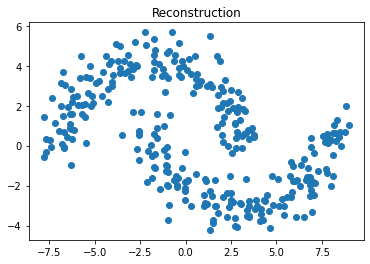

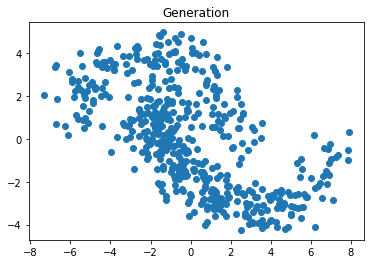

Epoch: 2600 loss: 2.3049 recon_loss: 0.4073 kl_loss: 1.8976 avg mean: -0.0636 avg std: 0.3351


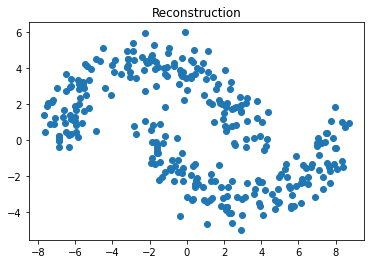

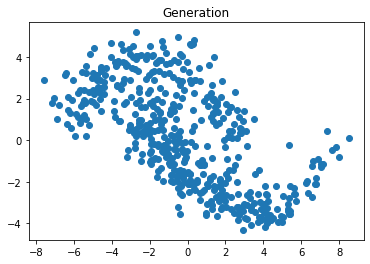

Epoch: 2800 loss: 2.3134 recon_loss: 0.3410 kl_loss: 1.9724 avg mean: 0.0203 avg std: 0.3151


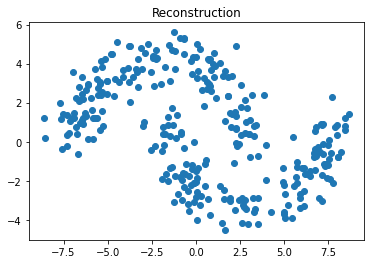

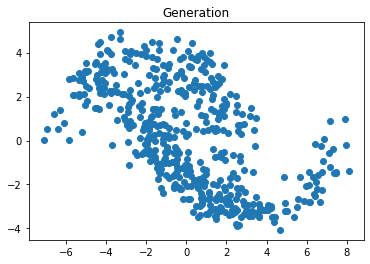

Epoch: 3000 loss: 2.2940 recon_loss: 0.2807 kl_loss: 2.0133 avg mean: 0.1519 avg std: 0.3252


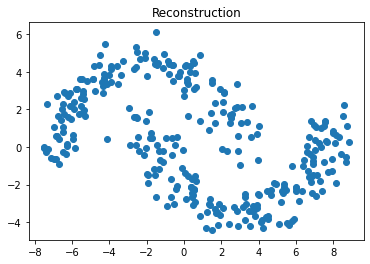

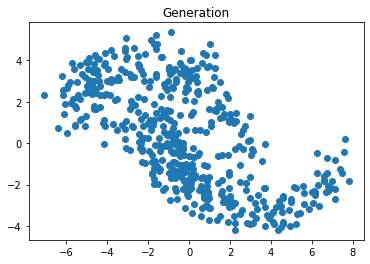

Epoch: 3200 loss: 2.2938 recon_loss: 0.2172 kl_loss: 2.0766 avg mean: 0.0001 avg std: 0.2974


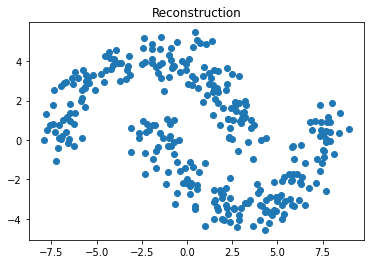

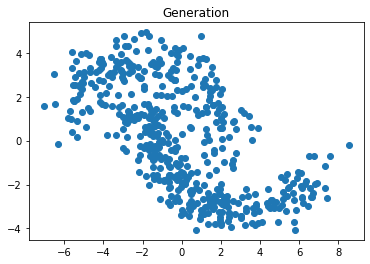

Epoch: 3400 loss: 2.3008 recon_loss: 0.1817 kl_loss: 2.1191 avg mean: -0.0530 avg std: 0.2689


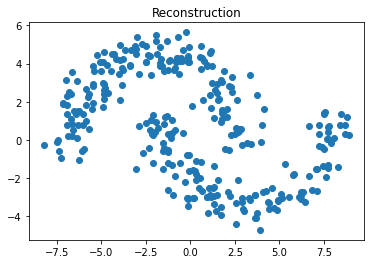

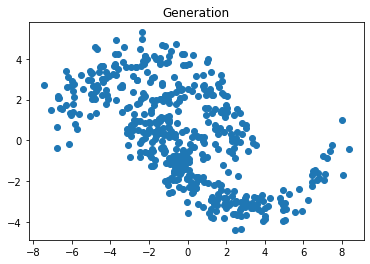

Epoch: 3600 loss: 2.3007 recon_loss: 0.1555 kl_loss: 2.1452 avg mean: -0.0644 avg std: 0.2710


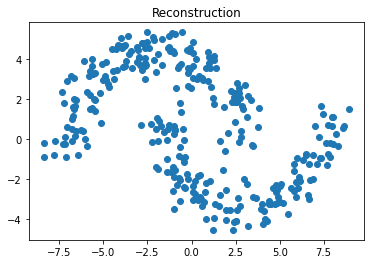

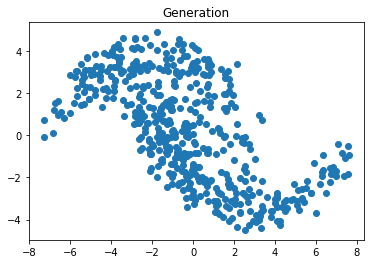

Epoch: 3800 loss: 2.2937 recon_loss: 0.1156 kl_loss: 2.1782 avg mean: -0.1101 avg std: 0.2580


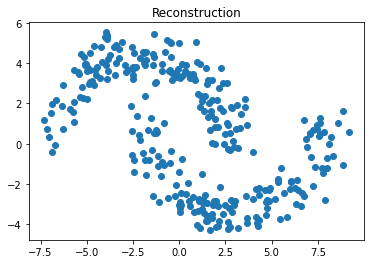

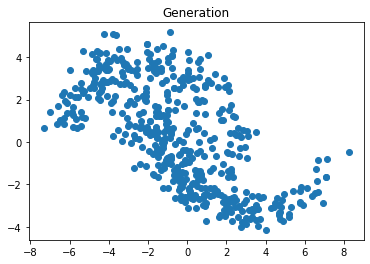

Epoch: 4000 loss: 2.2946 recon_loss: 0.1042 kl_loss: 2.1904 avg mean: -0.0170 avg std: 0.2655


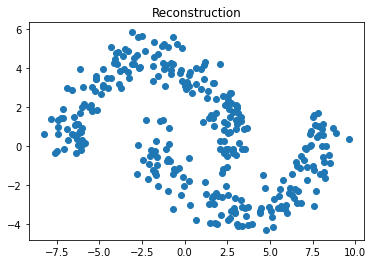

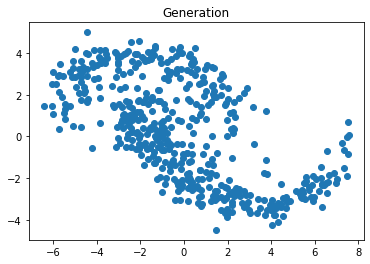

Epoch: 4200 loss: 2.2915 recon_loss: 0.0821 kl_loss: 2.2094 avg mean: -0.0530 avg std: 0.2524


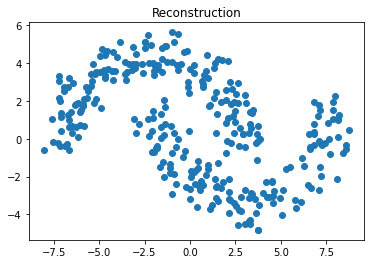

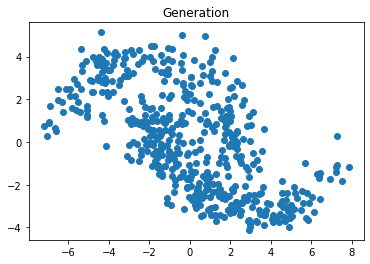

Epoch: 4400 loss: 2.2882 recon_loss: 0.0659 kl_loss: 2.2222 avg mean: 0.0406 avg std: 0.2498


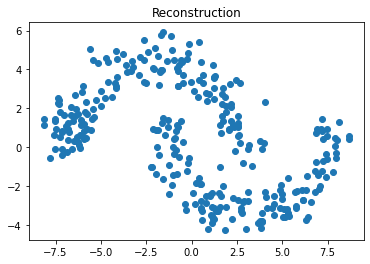

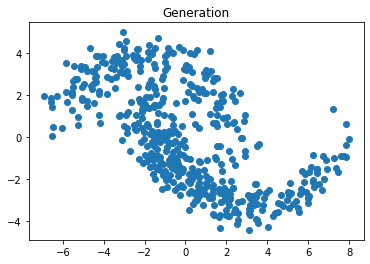

Epoch: 4600 loss: 2.3018 recon_loss: 0.0702 kl_loss: 2.2316 avg mean: -0.0135 avg std: 0.2408


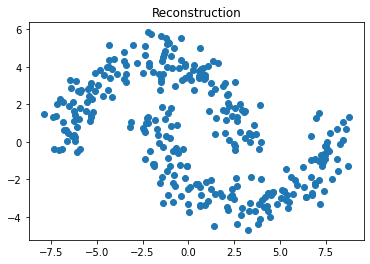

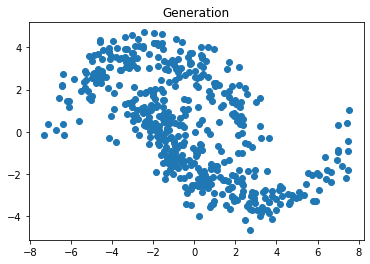

Epoch: 4800 loss: 2.2900 recon_loss: 0.0427 kl_loss: 2.2472 avg mean: 0.0297 avg std: 0.2478


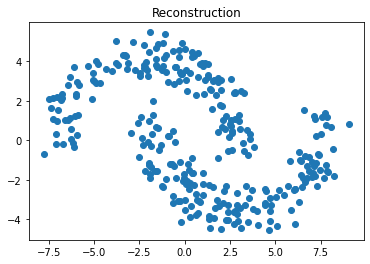

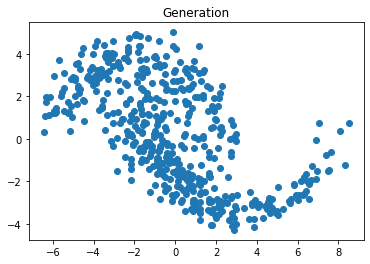

Epoch: 5000 loss: 2.2923 recon_loss: 0.0247 kl_loss: 2.2676 avg mean: 0.0417 avg std: 0.2346


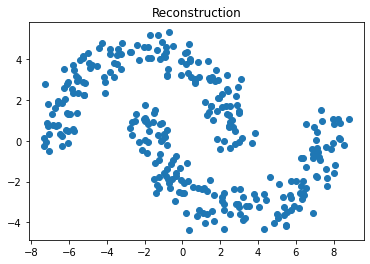

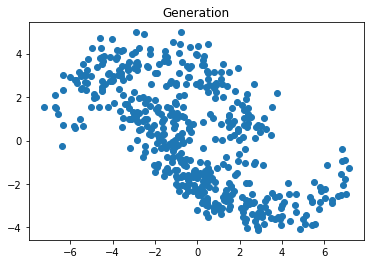

Epoch: 5200 loss: 2.2814 recon_loss: 0.0004 kl_loss: 2.2809 avg mean: 0.0327 avg std: 0.2355


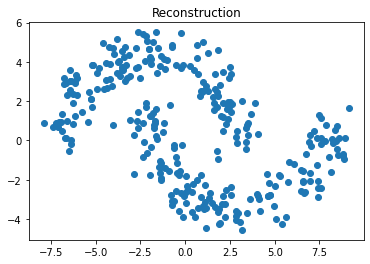

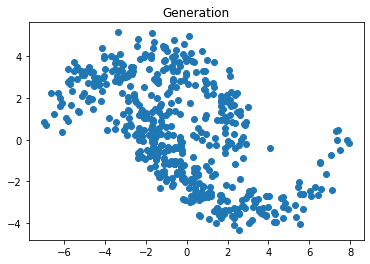

Epoch: 5400 loss: 2.2948 recon_loss: 0.0098 kl_loss: 2.2850 avg mean: 0.1171 avg std: 0.2425


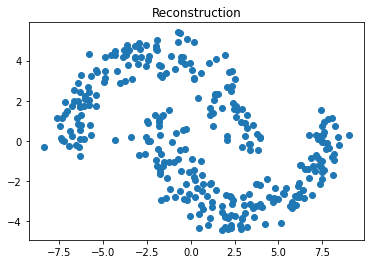

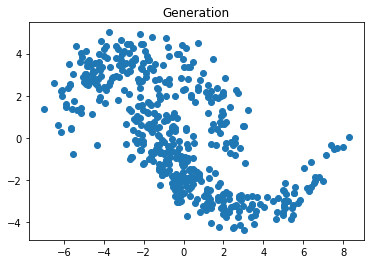

Epoch: 5600 loss: 2.2878 recon_loss: -0.0071 kl_loss: 2.2949 avg mean: -0.0026 avg std: 0.2401


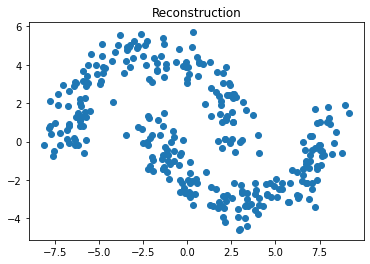

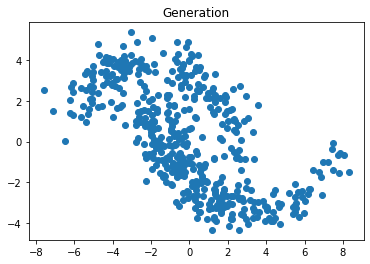

Epoch: 5800 loss: 2.2868 recon_loss: -0.0005 kl_loss: 2.2873 avg mean: 0.0677 avg std: 0.2391


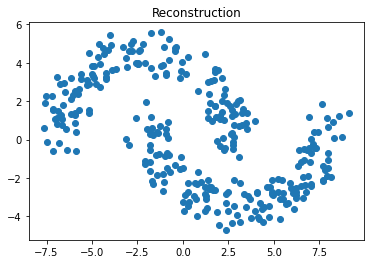

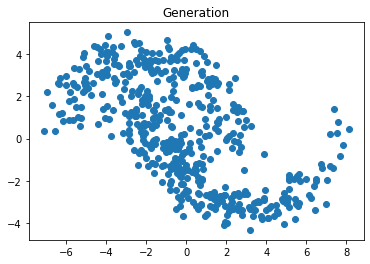

Epoch: 6000 loss: 2.2849 recon_loss: -0.0194 kl_loss: 2.3043 avg mean: -0.0365 avg std: 0.2348


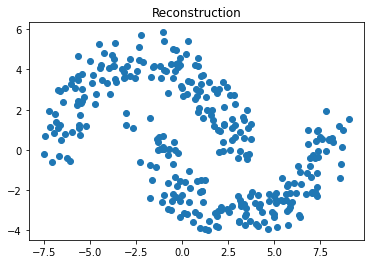

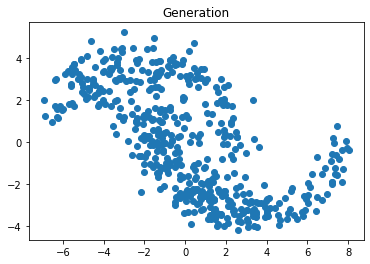

Epoch: 6200 loss: 2.2844 recon_loss: -0.0341 kl_loss: 2.3185 avg mean: 0.0012 avg std: 0.2334


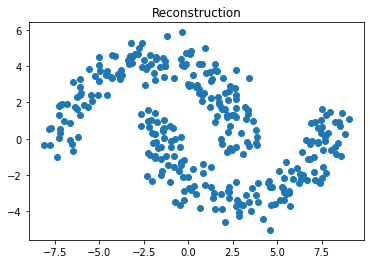

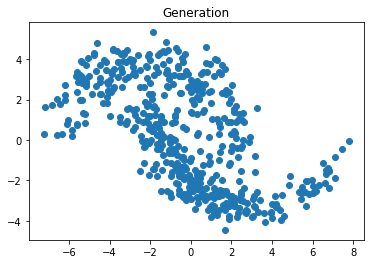

Epoch: 6400 loss: 2.2909 recon_loss: -0.0457 kl_loss: 2.3366 avg mean: 0.0266 avg std: 0.2342


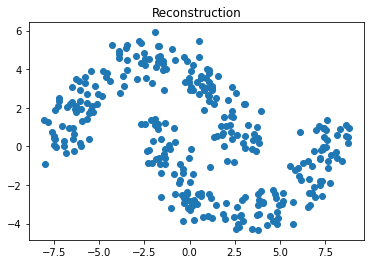

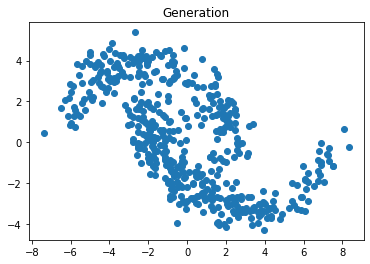

Epoch: 6600 loss: 2.2822 recon_loss: -0.0464 kl_loss: 2.3286 avg mean: -0.0635 avg std: 0.2299


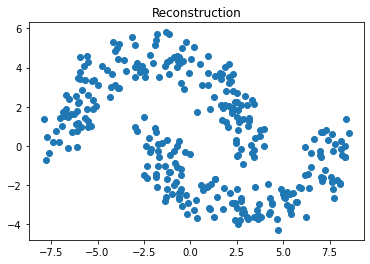

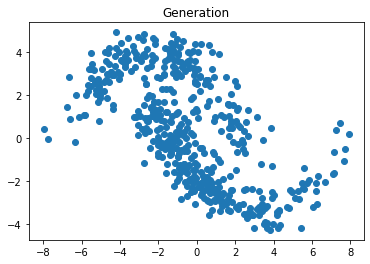

Epoch: 6800 loss: 2.2698 recon_loss: -0.0613 kl_loss: 2.3311 avg mean: -0.0107 avg std: 0.2343


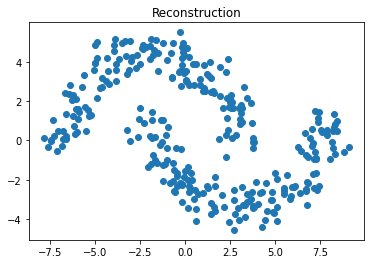

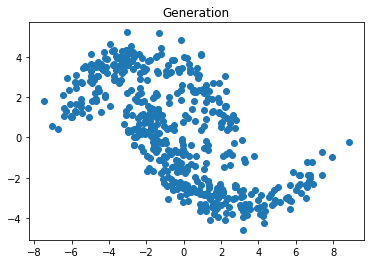

Epoch: 7000 loss: 2.2757 recon_loss: -0.0597 kl_loss: 2.3355 avg mean: 0.0837 avg std: 0.2333


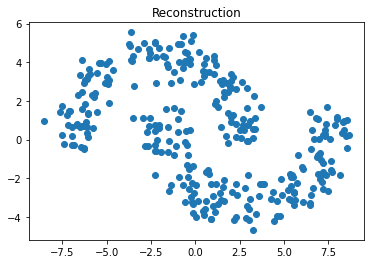

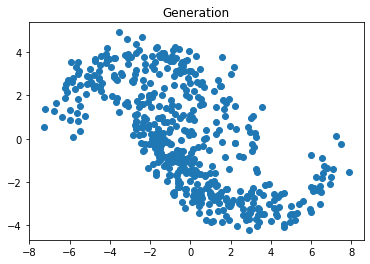

Epoch: 7200 loss: 2.2808 recon_loss: -0.0786 kl_loss: 2.3594 avg mean: 0.1394 avg std: 0.2325


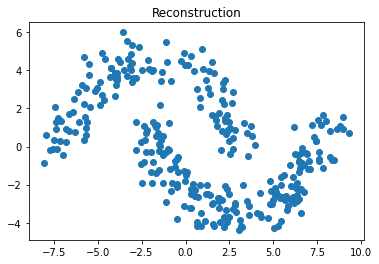

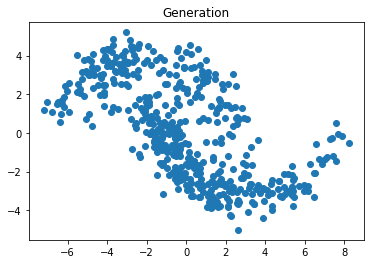

Epoch: 7400 loss: 2.2858 recon_loss: -0.0731 kl_loss: 2.3589 avg mean: 0.0756 avg std: 0.2302


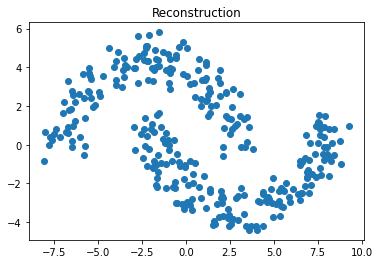

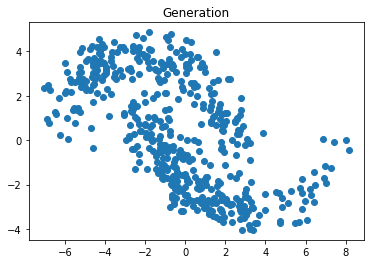

In [ ]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

In [ ]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

Text(0.5, 1.0, 'Data in latent space')

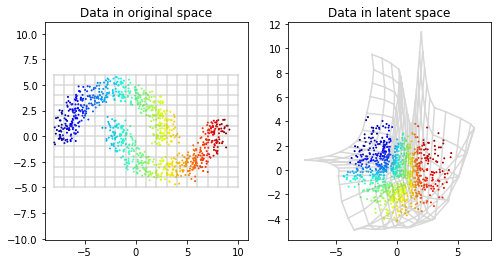

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")

vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_data = vae.encoder(torch.Tensor(data).to(device)).cpu().detach().numpy()
enc_grid = vae.encoder(torch.Tensor(grid).to(device)).cpu().detach().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

Text(0.5, 1.0, 'Generated data in original space')

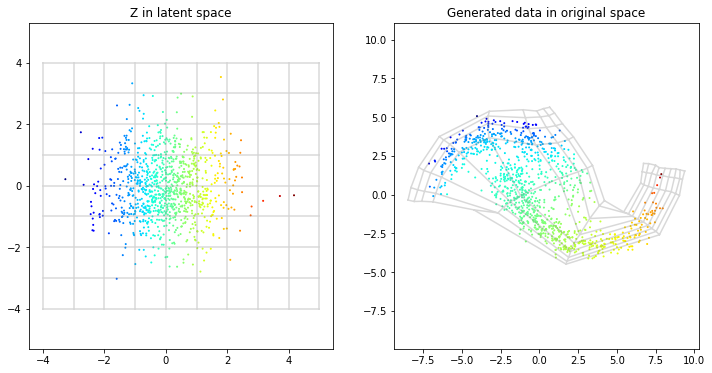

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid

x_gen = vae.decoder(torch.Tensor(latent_samples).to(device)).cpu().detach().numpy()
grid_gen = vae.decoder(torch.Tensor(latent_grid).to(device)).cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## GAN

In [6]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)

In [7]:
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    return -torch.mean(torch.log(DG + eps))


def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    return -torch.mean(torch.log(1 - DG + eps) + torch.log(DR + eps))


In [ ]:
z_dim = 2
hid_dim = 64
lr = 0.0001

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

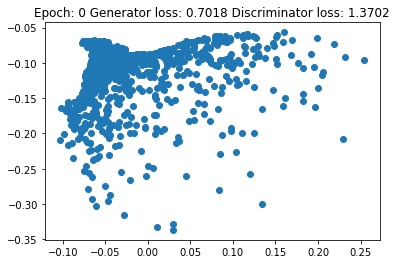

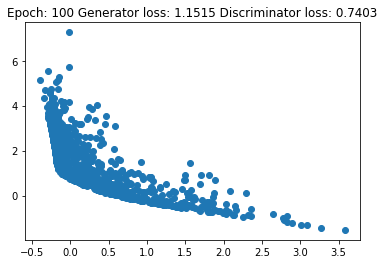

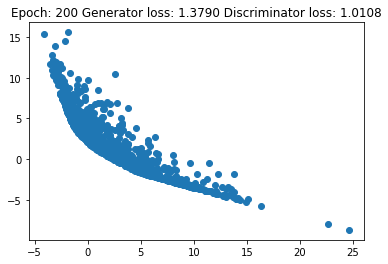

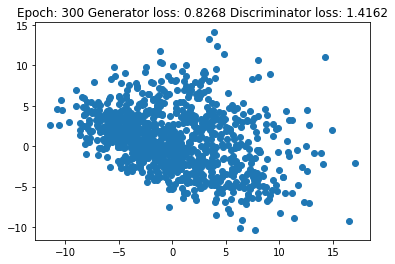

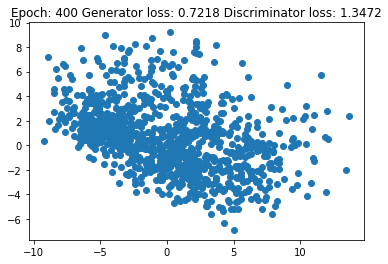

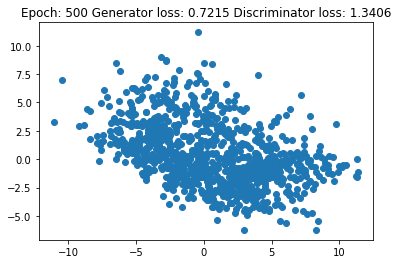

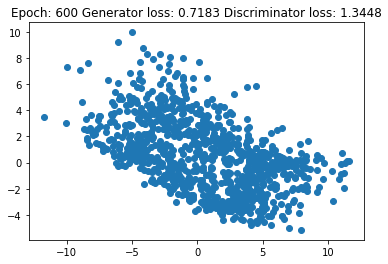

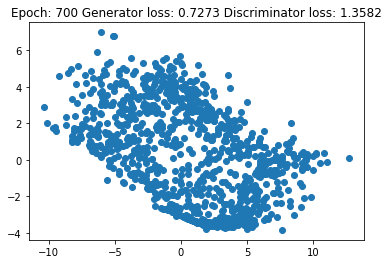

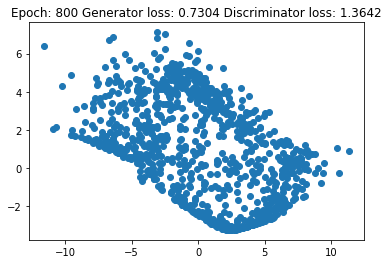

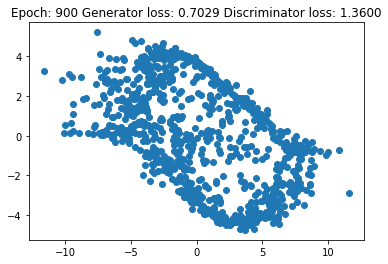

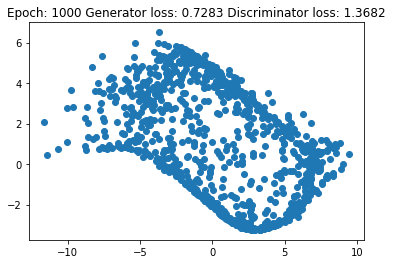

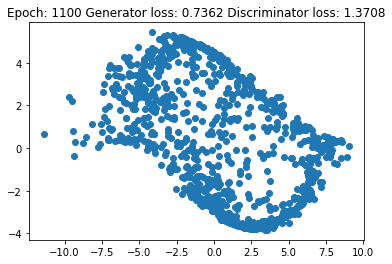

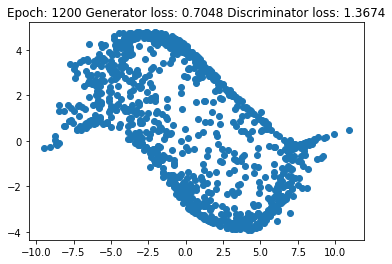

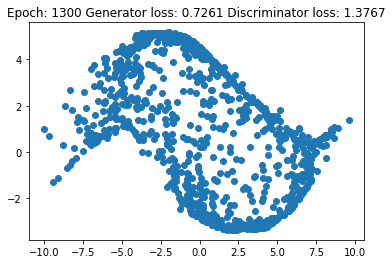

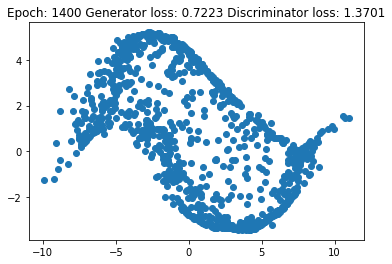

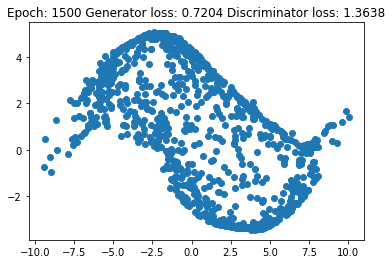

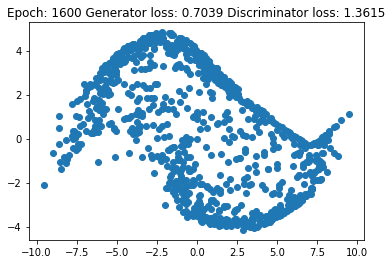

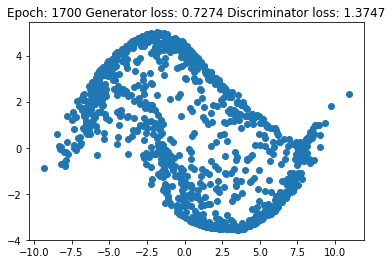

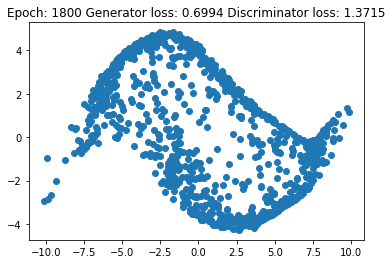

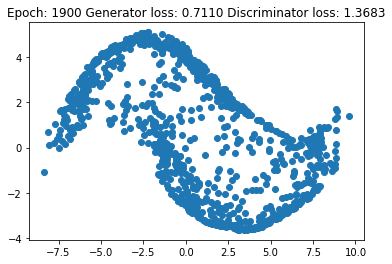

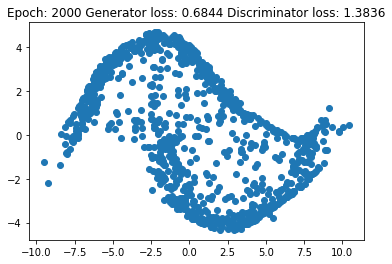

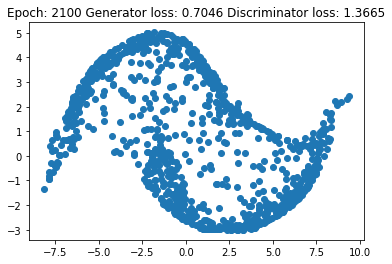

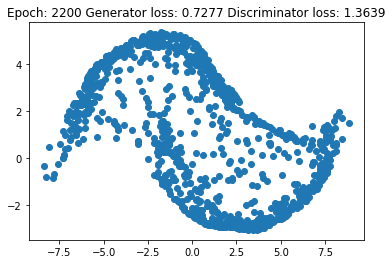

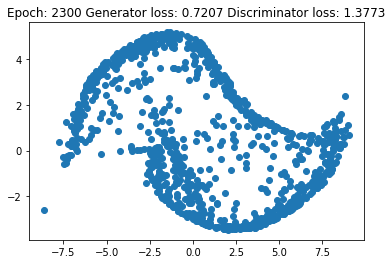

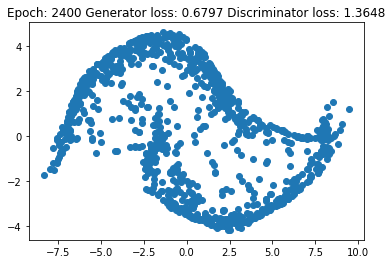

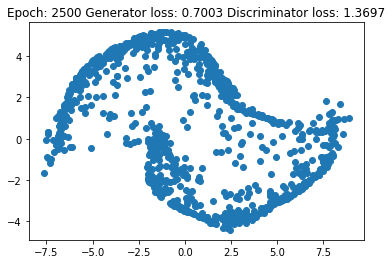

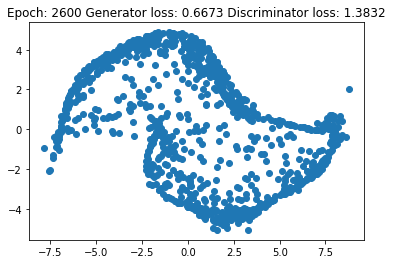

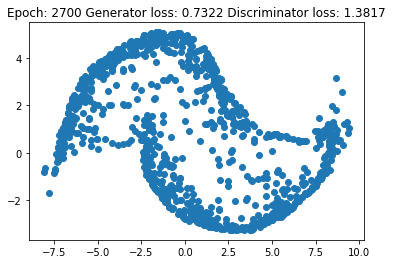

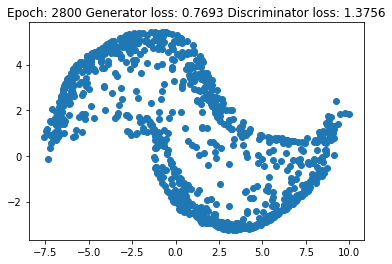

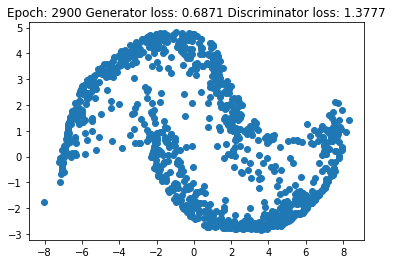

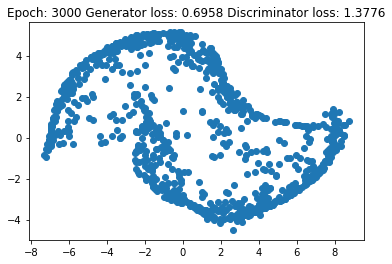

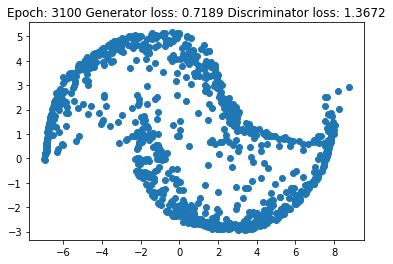

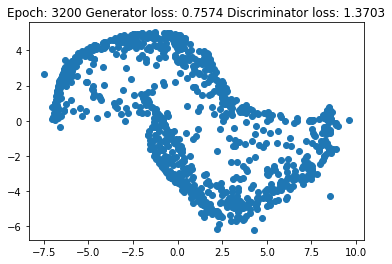

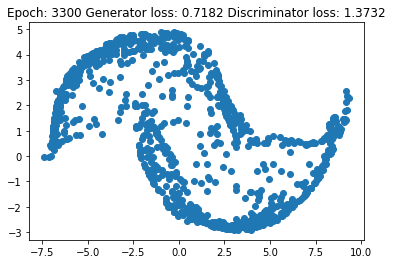

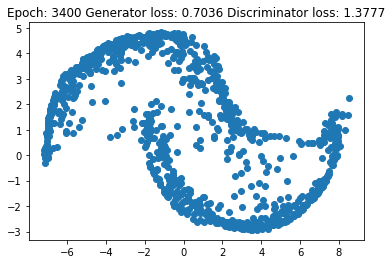

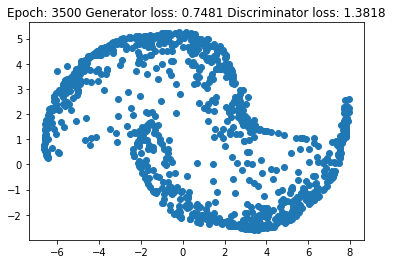

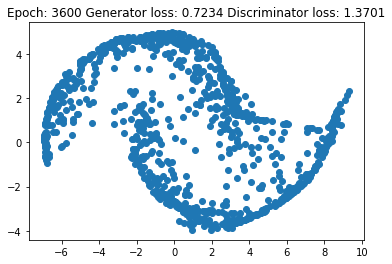

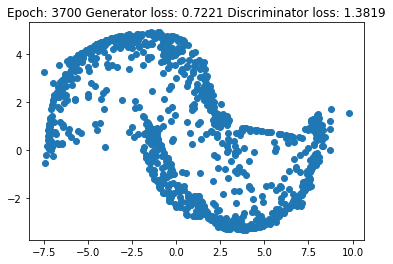

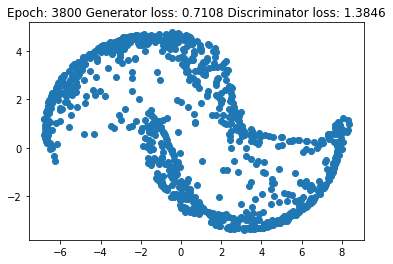

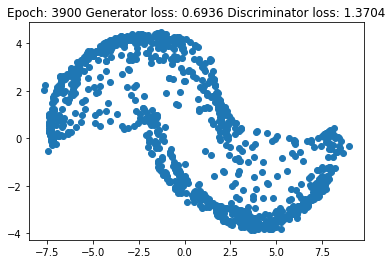

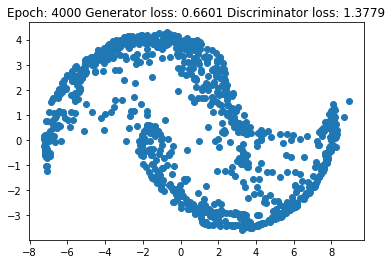

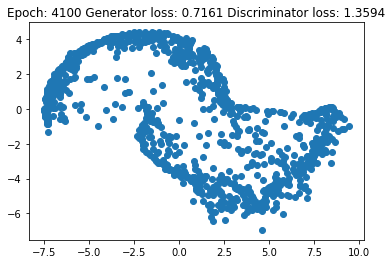

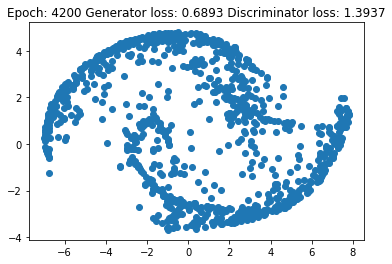

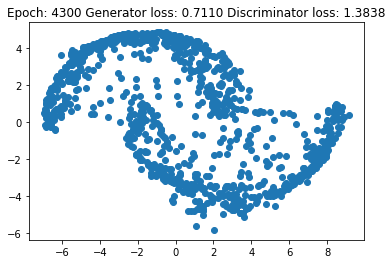

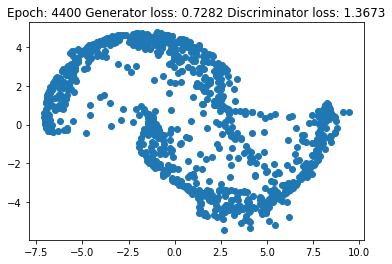

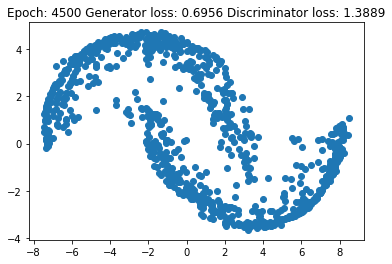

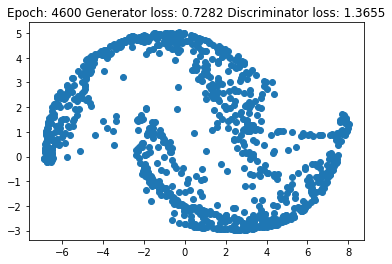

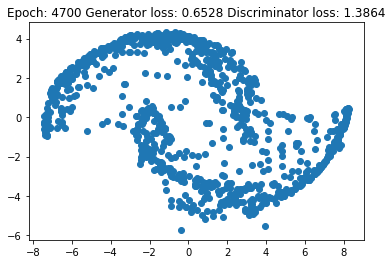

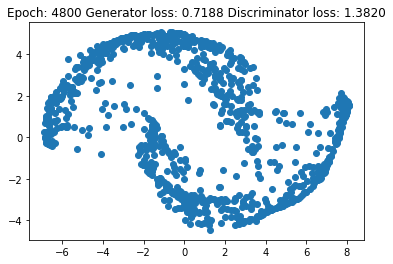

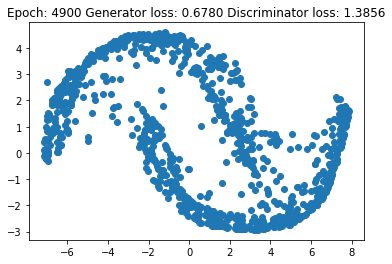

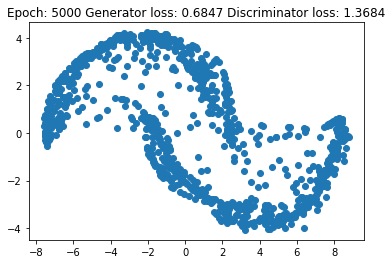

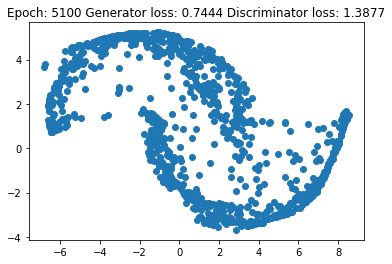

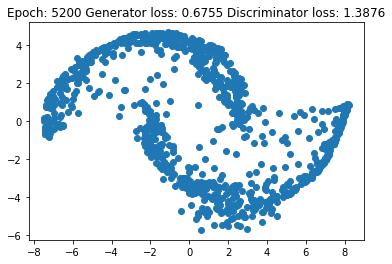

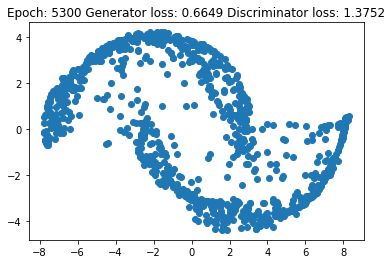

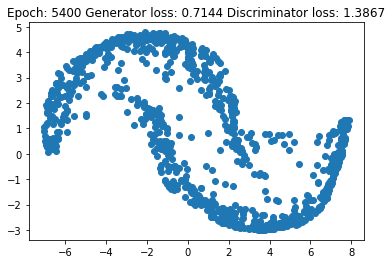

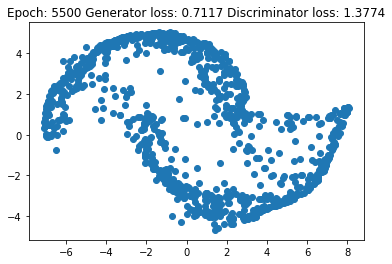

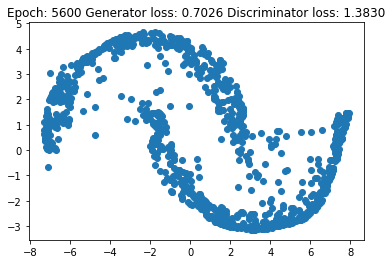

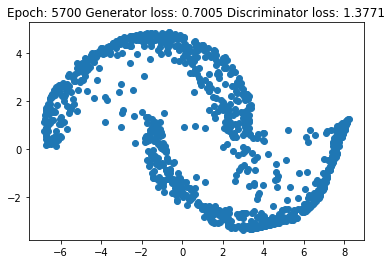

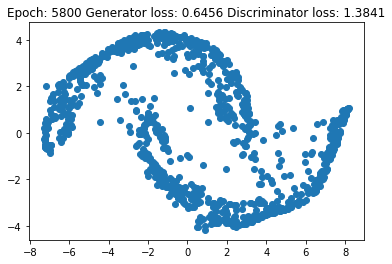

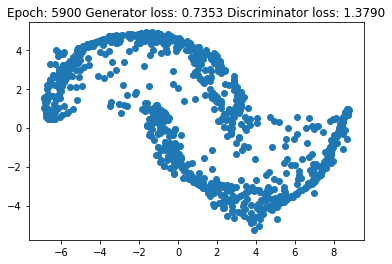

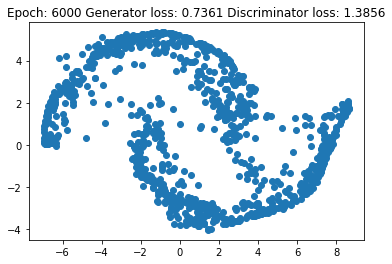

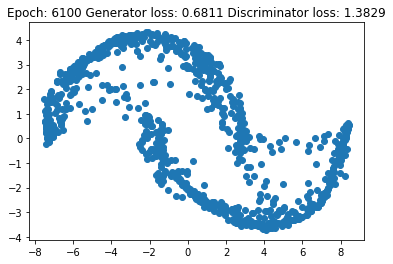

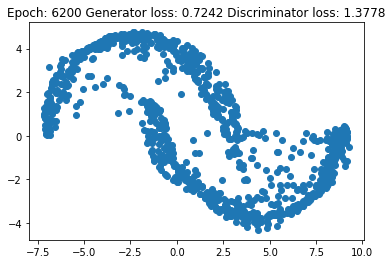

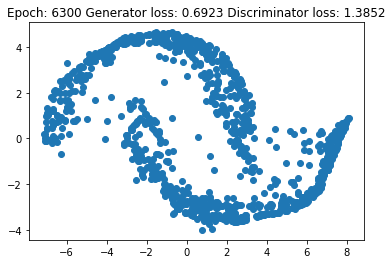

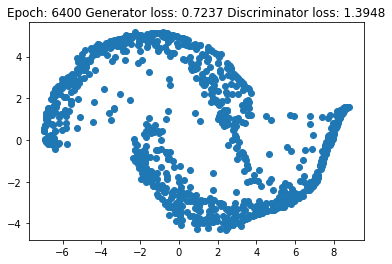

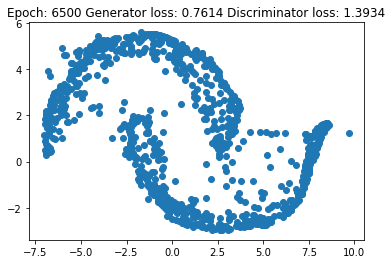

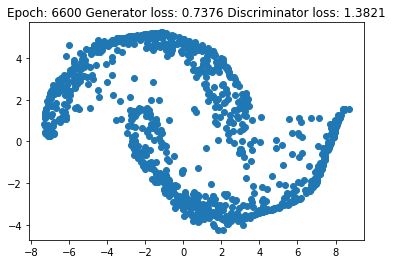

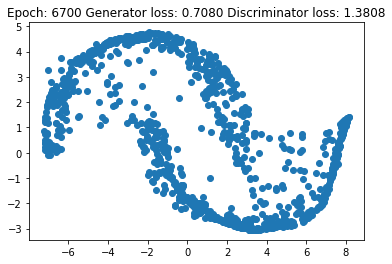

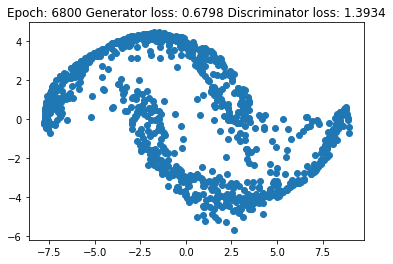

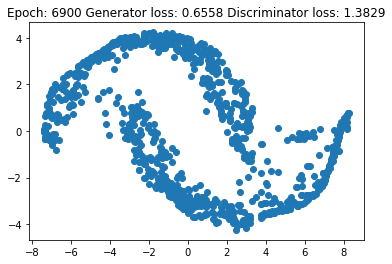

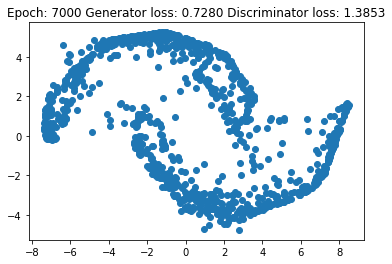

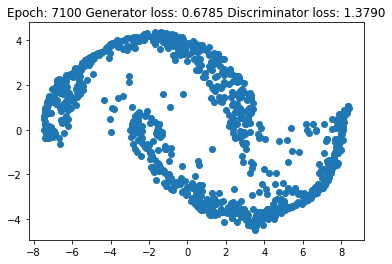

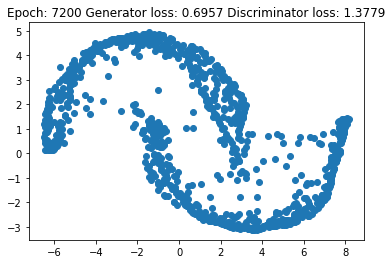

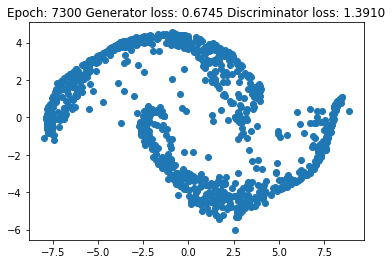

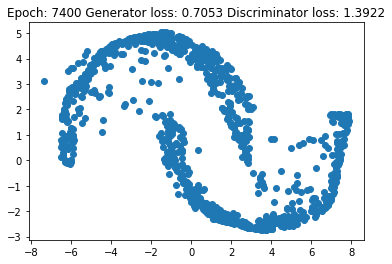

In [ ]:
for i in range(7500):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, in moons_dl:
        x = x.float().to(device)

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G.forward(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()


        G_loss = generator_loss(D(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss = discriminator_loss(D(x), D(x_fake_detached))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 100 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title(
                f"Epoch: {i} Generator loss: {G_loss_acc / len(moons) :.4f} Discriminator loss: {D_loss_acc / len(moons) :.4f}"
            )
            plt.show()

Text(0.5, 1.0, 'Generated data in original space')

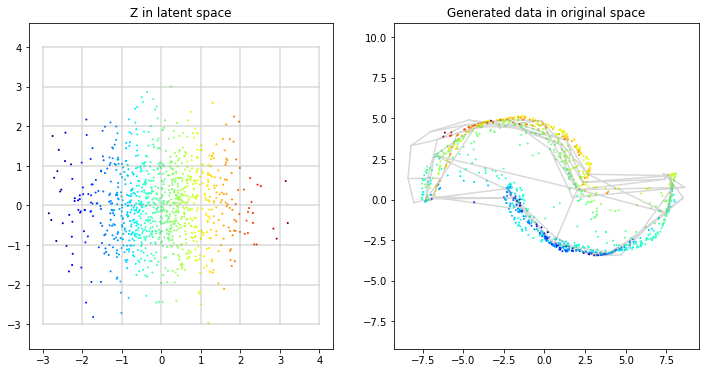

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

G.eval()
# TODO: compute the projection into data space of the latent saples and the grid

x_gen = G(torch.Tensor(latent_samples).to(device)).cpu().detach().numpy()
grid_gen = G(torch.Tensor(latent_grid).to(device)).cpu().detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

Q: Is the GAN generating all possible samples? Is it concentrating more on some regions of the data space?

A: No, generator its deterministic function but it doesn't have to be a bijection at all. It has more points closer to the center.

## Normalizing Flow

In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2 = x[:, 0, None], x[:, 1, None]
        if self.odd:
            x1, x2 = x2, x1

        s = self.s(x1)
        t = self.t(x1)
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2*s + t

        if self.odd:
            x1, x2 = x2, x1

        # Add log determinant of the Jacobian
        ldetJ += s.abs().log()

        return torch.cat([x1, x2], dim=1), ldetJ

    def invert(self, z):
        z1, z2 = z[:, 0, None], z[:, 1, None]
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(z1)
        t = self.t(z1)
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2 - t) / s

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [ ]:
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    return -(prior_z.log_prob(z) + ldetJ).mean()


In [ ]:
n_coupling_layers = 6
hid_dim = 64
lr = 0.003

flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim).to(device)
optimizer = optim.Adam(flow.parameters(), lr=lr)
prior_z = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

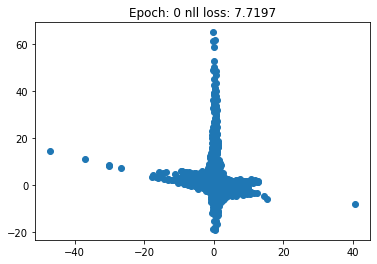

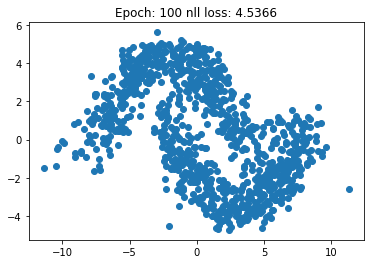

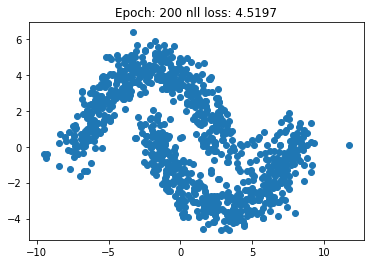

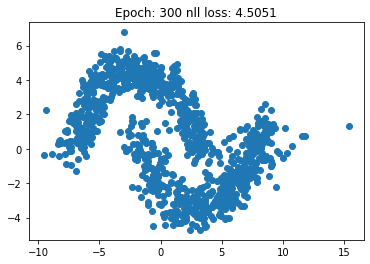

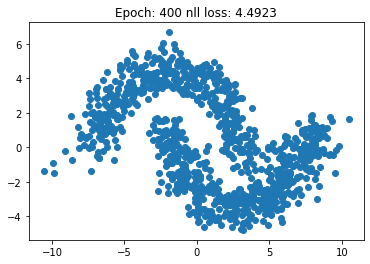

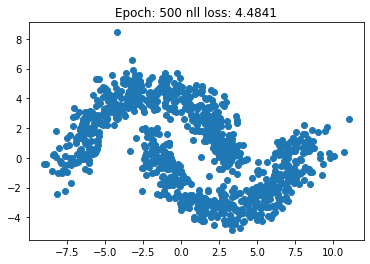

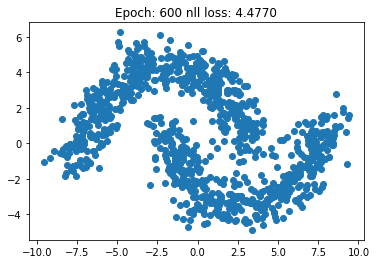

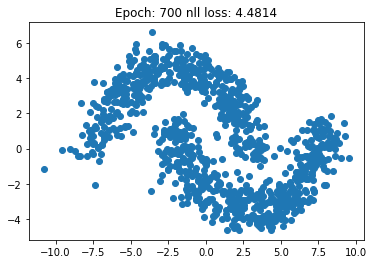

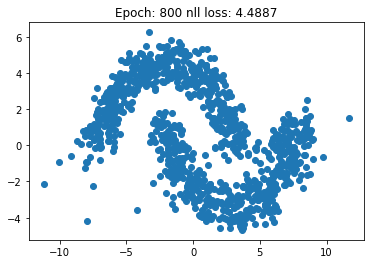

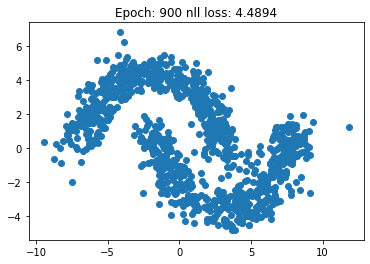

In [ ]:
for i in range(1000):
    loss_acc = 0.0
    flow.train()
    for x, in moons_dl:
        x = x.float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 1e2
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if i % 100 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plt.scatter(x[:, 0], x[:, 1])
            plt.title(f"Epoch: {i} nll loss: {loss_acc / len(moons) :.4f}")
            plt.show()

(-5.0, 5.0)

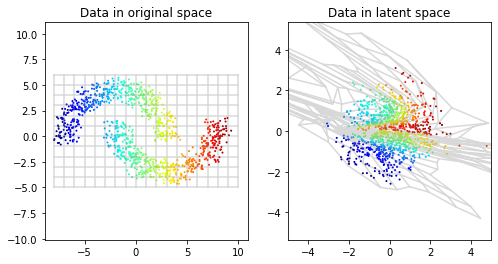

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")


plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_grid = flow(torch.Tensor(grid).to(device))[0].cpu().detach().numpy()
enc_data = flow(torch.Tensor(data).to(device))[0].cpu().detach().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Text(0.5, 1.0, 'Generated data in original space')

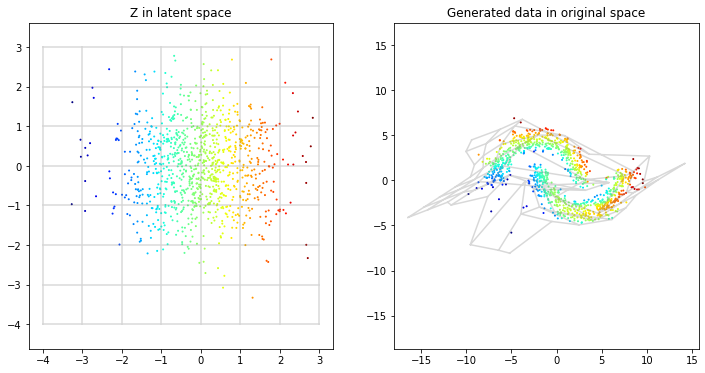

In [ ]:
latent_samples = prior_z.sample((1000,)).cpu()

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

# TODO: compute the projection into data space of the latent saples and the grid

x_gen = flow.invert(latent_samples.to(device)).detach().cpu().numpy()
grid_gen = flow.invert(torch.Tensor(latent_grid).to(device)).detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## MNIST

In [2]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [3]:
torchvision.datasets.MNIST.mirrors = [ 'http://yann.lecun.com/exdb/mnist/',
             'https://ossci-datasets.s3.amazonaws.com/mnist/',
            ] 
torchvision.datasets.MNIST.resources = [ 
              ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"), 
              ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
              ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
              ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c"),
            ]

In [4]:
# Load the data

batch_size = 128
data_path = "./data"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [8]:
z_dim = 128
hid_dim = 512
lr = 0.0005

G = Generator(in_dim=z_dim, hid_dim=hid_dim, out_dim=784).to(device)
D = Discriminator(in_dim=784, hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [9]:
for i in range(100):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x,_ in mnist_loaders["train"]:
        x = x.view(x.size(0), -1)
        x = x.float().to(device)
        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G.forward(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss = discriminator_loss(D(x), D(x_fake_detached))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 10 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            print("Epoch: {} Generator loss: {:.4f} Discriminator loss: {:.4f}".format(i,G_loss_acc / len(mnist_loaders["train"]), D_loss_acc / len(mnist_loaders["train"])))

Epoch: 0 Generator loss: 493.3606 Discriminator loss: 34.5706
Epoch: 10 Generator loss: 880.0231 Discriminator loss: 14.9357
Epoch: 20 Generator loss: 781.7293 Discriminator loss: 15.5175
Epoch: 30 Generator loss: 780.2700 Discriminator loss: 18.2425
Epoch: 40 Generator loss: 791.0307 Discriminator loss: 18.2725
Epoch: 50 Generator loss: 793.5414 Discriminator loss: 16.8397
Epoch: 60 Generator loss: 772.0978 Discriminator loss: 15.3178
Epoch: 70 Generator loss: 776.9163 Discriminator loss: 14.7413
Epoch: 80 Generator loss: 758.9859 Discriminator loss: 14.3353
Epoch: 90 Generator loss: 788.2167 Discriminator loss: 12.7268


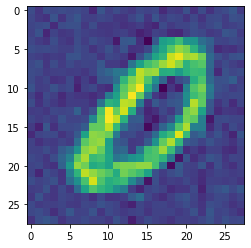

In [19]:
plt.imshow(G(torch.randn(x.size(0), z_dim, device=device))[0].detach().cpu().reshape((28, 28)))
plt.show()

#### Linear interpolation




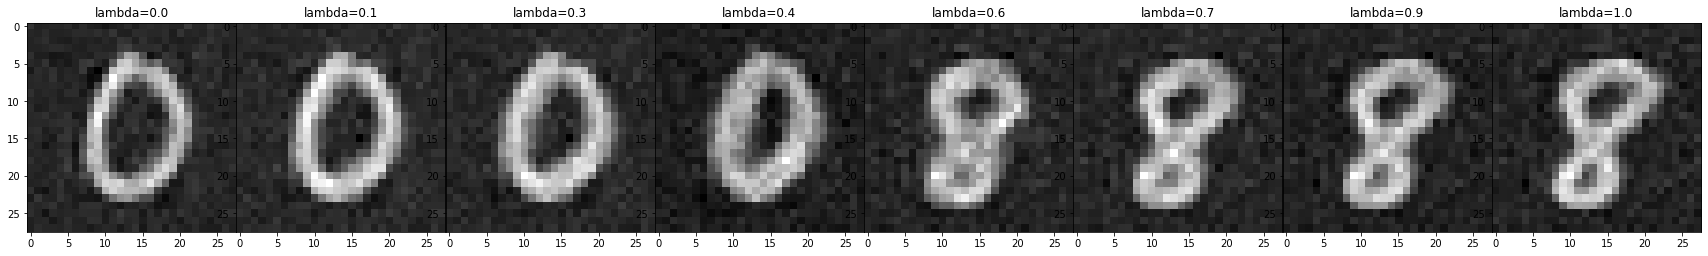

In [10]:
def interpolation(lmbda, model, A, B):
    with torch.no_grad():
        inter_latent = lmbda* A + (1- lmbda) * B
        inter_image = model(inter_latent.to(device))
        inter_image = inter_image.cpu()

        return inter_image

A = torch.randn(1, z_dim, device=device)
B = torch.randn(1, z_dim, device=device)

lambda_range=np.linspace(0,1,8)

fig, axs = plt.subplots(1,8, figsize=(30, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for ind,l in enumerate(lambda_range):
    img = interpolation(float(l), G, A, B)
    
    img = img.numpy().reshape(-1,28,28)
    axs[ind].imshow(img[0,:,:], cmap='gray')
    axs[ind].set_title('lambda='+str(round(l,1)))
plt.show() 

#### Non-Linear interpolation


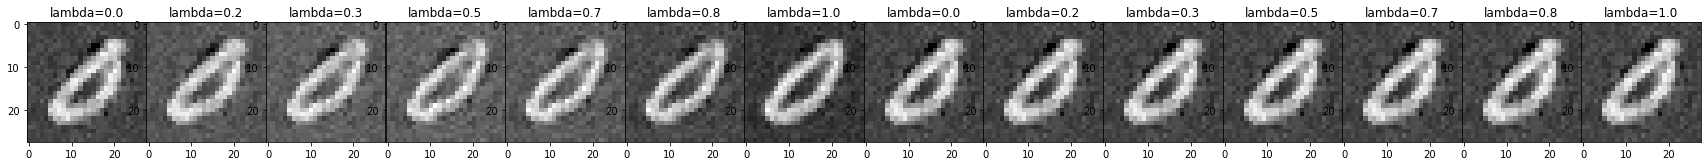

In [17]:

def interpolation(lmbda, model, A, B, curve):
    with torch.no_grad():      
        inter_latent = lmbda* A + (1- lmbda) * B
        if curve:
          inter_latent = inter_latent *torch.norm(A)/torch.norm(inter_latent)
        inter_image = model(inter_latent.to(device))
        inter_image = inter_image.cpu()

        return inter_image

A = torch.randn(1, z_dim, device=device)
B = torch.randn(1, z_dim, device=device)

if torch.norm(A) > torch.norm(B):
  A,B = B,A

C = B * torch.norm(A)/torch.norm(B)

AC = np.linspace(0,1,7)
CB = np.linspace(0,1,7)

fig, axs = plt.subplots(1,14, figsize=(30, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

for ind,l in enumerate(AC):
    img = interpolation(float(l), G, A, C, True)
    img = img.numpy().reshape(-1,28,28)
    axs[ind].imshow(img[0,:,:], cmap='gray')
    axs[ind].set_title('lambda='+str(round(l,1)))

for ind,l in enumerate(CB):
    img = interpolation(float(l), G, C, B, False)
    img = img.numpy().reshape(-1,28,28)
    axs[ind+7].imshow(img[0,:,:], cmap='gray')
    axs[ind+7].set_title('lambda='+str(round(l,1)))
plt.show() 

## Conditional Gan

In [91]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        in_dim += 10
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)

        in_dim += 10
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        return self.layers(x)

In [92]:
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    return -torch.mean(torch.log(DG + eps))


def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    return -torch.mean(torch.log(1 - DG + eps) + torch.log(DR + eps))


In [93]:
z_dim = 128
hid_dim = 512
lr = 0.0003

G = Generator(in_dim=z_dim, hid_dim=hid_dim, out_dim=784).to(device)
D = Discriminator(in_dim=784, hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [95]:
for i in range(100):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for (x,y) in mnist_loaders["train"]:
        if x.size(0) == 128:
          x = x.view(x.size(0), -1)
          # y = x.view(y.size(0), -1)
          x = x.float().to(device)
          y = y.to(device)
          # print(y)
          # Generate fake data from z ~ N(0,1).
          # Calculate Generator loss.
          z = torch.randn(x.size(0), z_dim, device=device)
          fake_labels = torch.LongTensor(np.random.randint(0, 10, batch_size)).cuda()
          x_fake = G(z,fake_labels)  # Use the generator to compute x_Fake

          # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
          x_fake_detached = x_fake.detach()
          fake_labels_detached = fake_labels.detach()

          G_loss = generator_loss(D(x_fake, fake_labels))  # Now use the discriminator and compute generator loss

          G_optimizer.zero_grad()
          G_loss.backward()
          G_optimizer.step()

          # Calculate Discriminator loss.
          # Remember to use x_fake_detached to prevent backpropagating through generator!
          # print(y)
          # print(fake_labels_detached)
          D_loss = discriminator_loss(D(x, y), D(x_fake_detached, fake_labels_detached))

          D_optimizer.zero_grad()
          D_loss.backward()
          D_optimizer.step()

          G_loss_acc += G_loss.item() * len(x)
          D_loss_acc += D_loss.item() * len(x)

    if i % 10 == 0:
        G.eval()
        with torch.no_grad():
            print("Epoch: {} Generator loss: {:.4f} Discriminator loss: {:.4f}".format(i,G_loss_acc / len(mnist_loaders["train"]), D_loss_acc / len(mnist_loaders["train"])))

Epoch: 0 Generator loss: 575.3354 Discriminator loss: 8.0669
Epoch: 10 Generator loss: 1117.5080 Discriminator loss: 4.9917
Epoch: 20 Generator loss: 925.0236 Discriminator loss: 9.6416
Epoch: 30 Generator loss: 795.3789 Discriminator loss: 12.4529
Epoch: 40 Generator loss: 733.9277 Discriminator loss: 14.5444
Epoch: 50 Generator loss: 748.8041 Discriminator loss: 17.1318
Epoch: 60 Generator loss: 709.9343 Discriminator loss: 19.5554
Epoch: 70 Generator loss: 790.3289 Discriminator loss: 17.4848
Epoch: 80 Generator loss: 974.5683 Discriminator loss: 13.9981
Epoch: 90 Generator loss: 914.8864 Discriminator loss: 15.9707


In [102]:
labels = torch.LongTensor([i for i in range(10) for _ in range(10)]).cuda()
z = torch.randn(100, z_dim).cuda()

In [158]:
from torchvision.utils import make_grid
imgs = G(z, labels).reshape(100,1,28,28)
grid = make_grid(imgs, nrow=10, normalize=False)
grid.shape

torch.Size([3, 302, 302])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 301.5, 301.5, -0.5)

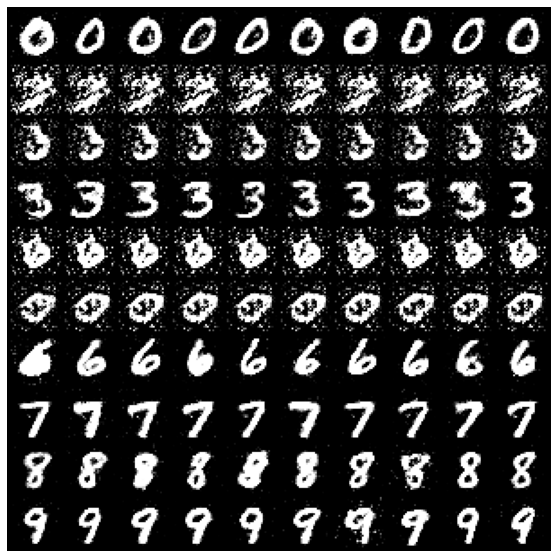

In [159]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1,2,0).cpu().detach().numpy(), cmap='binary')
ax.axis('off')